In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# Get the data.

dimuon = pd.read_csv('http://opendata.cern.ch/record/545/files/Dimuon_DoubleMu.csv')

How many GeVs should our step be (1 should do)? 1
From what GeV shall we start (0 or over is good)? 0
How far shall we look at (120 is probably fine)? 120


The median of events in step 0 is: 439.5
The mode of events in step 0 is: 596

The median of events in step 1 is: 578.0
The mode of events in step 1 is: 894

The median of events in step 2 is: 455.0
The mode of events in step 2 is: 561

The median of events in step 3 is: 227.0
The mode of events in step 3 is: 4310

The median of events in step 4 is: 116.5
The mode of events in step 4 is: 133

The median of events in step 5 is: 105.5
The mode of events in step 5 is: 128

The median of events in step 6 is: 103.5
The mode of events in step 6 is: 119

The median of events in step 7 is: 115.0
The mode of events in step 7 is: 128

The median of events in step 8 is: 202.0
The mode of events in step 8 is: 301

The median of events in step 9 is: 500.0
The mode of events in step 9 is: 1311

The median of events in step 10 is: 564.0
The mode 

The median of events in step 114 is: 0.0
The mode of events in step 114 is: 1

The median of events in step 115 is: 0.0
The mode of events in step 115 is: 3

The median of events in step 116 is: 0.0
The mode of events in step 116 is: 1

The median of events in step 117 is: 0.0
The mode of events in step 117 is: 1

The median of events in step 118 is: 0.0
The mode of events in step 118 is: 1

The median of events in step 119 is: 0.0
The mode of events in step 119 is: 2



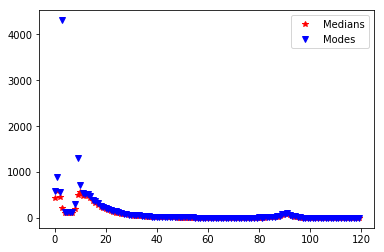

In [3]:
# First we define what part and how precisely we are looking at the data.

step = int(input('How many GeVs should our step be (1 should do)? '))
start = int(input('From what GeV shall we start (0 or over is good)? '))
end = int(input('How far shall we look at (120 is probably fine)? '))

print('\n')

bins = int((end-start)/step)

hist, edges = np.histogram(dimuon.M[(dimuon.M <= end) & (dimuon.M >= start)], bins)

# For statistical purposes, let's break our data to smaller pieces for the analysis.

medians = np.ones(len(edges)-1)
modes = np.ones(len(edges)-1)

for i in range (0,len(edges)-1):
    cut = dimuon.M[(dimuon.M >= start)&(dimuon.M < (start + step))]
    start = start + step
    breakdown, precision = np.histogram(cut, bins = 10)
    print('The median of events in step ' + str(i) + ' is: ' + str(np.median(breakdown)))
    print('The mode of events in step ' + str(i) + ' is: ' + str(max(breakdown)) + '\n')
    medians[i] = np.median(breakdown)
    modes[i] = max(breakdown)
    
plt.plot(medians, 'r*', label = 'Medians')
plt.plot(modes, 'vb', label = 'Modes')
plt.legend()
plt.show()